## Fairness/ALE Plots experiment notebook
An experiment to compute the effect of each feature in fairness using the ALE Plots method.



Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from aif360.sklearn.metrics.metrics import disparate_impact_ratio,average_odds_difference,statistical_parity_difference,equal_opportunity_difference 
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.preprocessing.base import Identity
from omnixai.preprocessing.encode import Ordinal
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from collections import OrderedDict
import warnings
from FALElib import *
from FALElib2D import *
from helpers import *

warnings.filterwarnings('ignore') 


## Loading Dataset/ Preprocessing

- `load_dataset()` function loads the chosen preprocessed dataset 
- `binarize()` function binarizes the sensitive attributes: 1 being set to be the privileged group and 0 as the unprivileged<br> and the label column: 1 being the positive outcome and 0 the negative.


In [3]:
X,y,feature_names,categorical_columns,prot_attr = load_dataset('adult')
X , y = binarize(X,y)
X.head()

age  workclass  education-num      marital-status  \
race sex                                                       
0    1    25.0    Private            7.0       Never-married   
1    1    38.0    Private            9.0  Married-civ-spouse   
     1    28.0  Local-gov           12.0  Married-civ-spouse   
0    1    44.0    Private           10.0  Married-civ-spouse   
1    1    34.0    Private            6.0       Never-married   

                 occupation   relationship  race  sex  capital-gain  \
race sex                                                              
0    1    Machine-op-inspct      Own-child     0    1           0.0   
1    1      Farming-fishing        Husband     1    1           0.0   
     1      Protective-serv        Husband     1    1           0.0   
0    1    Machine-op-inspct        Husband     0    1        7688.0   
1    1        Other-service  Not-in-family     1    1           0.0   

          capital-loss  hours-per-week native-country  
race sex                                               
0    1             0.0            40.0  United-States  
1    1             0.0            50.0  United-States  
     1             0.0            40.0  United-States  
0    1             0.0            40.0  United-States  
1    1             0.0            30.0  United-States

### Evaluate bias in original dataset

For each sensitive attribute we'll run `disparate_impact_ratio` which can be applied before training the model.<br>
Formula: P(unprivileged)/P(privileged)<br>

**How to interpret this metric:**

- Its output value ranges from 0 to 1
- The higher its value fairer is your dataset/model related to that protected attribute.
- Despite 1 being the perfect value for it (which means your dataset/model is fairest), a value greater than 0.8 is considered an acceptable bias.

In [4]:
for i in prot_attr:
    disparate_sex = disparate_impact_ratio(y, prot_attr=i)
    print(f'Disparate Impact Ratio for sensitive attribute {i} is : {disparate_sex}')
    print()

Disparate Impact Ratio for sensitive attribute sex is : 0.3634695423643793

Disparate Impact Ratio for sensitive attribute race is : 0.6037688467181627



The metric presents a really low value for both attributes, far even from 0.8 which is the acceptable value.

## Train Model
We train the model using `XGBClassifier()`

In [5]:
tabular_data = Tabular(
    data=X,
    categorical_columns=categorical_columns,
    #categorical_columns=[feature_names[i] for i in [3,4,6,7,8,12]],
    #target_column='label'
)

np.random.seed(1)
transformer = TabularTransform(cate_transform=Ordinal(), cont_transform=Identity()).fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

categorical_features = list(range(len(tabular_data.categorical_columns)))
categories = transformer.categories
categorical_names = {feature: categories[feature] for feature in categorical_features}

In [6]:
train, test, train_labels, test_labels = train_test_split(x , y, train_size=0.70,random_state=12345)
model = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
model.fit(train, train_labels)
pred = model.predict(test)
accuracy = accuracy_score(test_labels,pred)
print(f'The accuracy score of the model is: {accuracy}')

The accuracy score of the model is: 0.8691678337141594


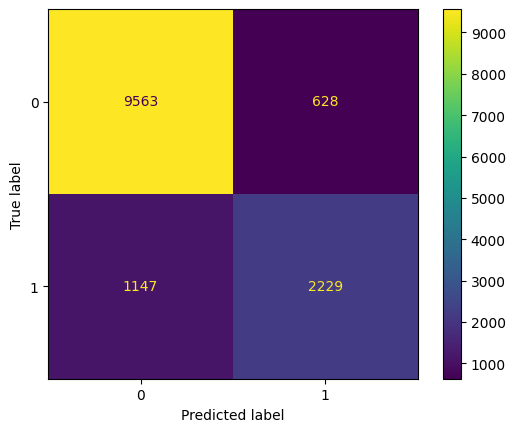

In [7]:
cm = confusion_matrix(test_labels,pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

## Fairness Metrics Used
- average_odds_difference() : returns the average of the difference in FPR and TPR for the unprivileged and privileged groups. A value of 0 indicates equality of odds.

- equal_opportunity_difference() :Returns the difference in recall scores (TPR) between the unprivileged and
    privileged groups. A value of 0 indicates equality of opportunity.
    
- statistical_parity_difference() : measures the difference that the majority and protected classes receive a favorable outcome. This measure must be equal to 0 to be fair.

*Reference Link:* https://aif360.readthedocs.io/en/stable/modules/sklearn.html?highlight=metrics#module-aif360.sklearn.metrics

In [8]:
for i in prot_attr:
    print(f'Fairness value for equal_opportunity_difference metric and protected attribute {i} is : {equal_opportunity_difference(test_labels, pred, prot_attr=i)}')
    print(f'Fairness value for statistical_parity_difference metric and protected attribute {i} is : {statistical_parity_difference(test_labels, pred, prot_attr=i)}')
    print(f'Fairness value for average_odds_difference metric and protected attribute {i} is : {average_odds_difference(test_labels, pred, prot_attr=i)}')
    print()

Fairness value for equal_opportunity_difference metric and protected attribute sex is : -0.050180627524695876
Fairness value for statistical_parity_difference metric and protected attribute sex is : -0.17696781462725278
Fairness value for average_odds_difference metric and protected attribute sex is : -0.056262580360289804

Fairness value for equal_opportunity_difference metric and protected attribute race is : -0.05378650147482811
Fairness value for statistical_parity_difference metric and protected attribute race is : -0.09518195898460674
Fairness value for average_odds_difference metric and protected attribute race is : -0.04230329592742893



### Fale 2D Plots for fairness metric `average_odds_difference`
ALE for two features estimate the second-order effect, which does not include the main effects of the features. <br> In other words, ALE for two features only shows the additional interaction effect of the two features.<br>If two features do not interact, the plot shows nothing.

In [9]:
test_2d = pd.DataFrame(data=test,columns=transformer.get_feature_names())
test_2d['labels'] = test_labels.values

In [10]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],average_odds_difference,'sex')


In [11]:
eff_grid

age,17.0,23.0,27.0,31.0,35.0,39.0,44.0,49.0,56.0,90.0
hours-per-week,,,,,,,,,,
1.000000,-0.347664,0.042756,0.005008,0.171582,0.135788,0.101897,0.101897,0.101897,0.101897,0.101897
30.000000,0.040312,-0.069267,-0.107015,-0.011871,0.052335,0.067055,0.055151,0.055151,-0.005426,-0.009914
40.000000,0.164885,0.055305,0.110522,0.021190,0.037387,0.014089,-0.045199,-0.126653,-0.106377,0.007432
46.000000,0.200355,0.090776,0.139663,0.066536,0.029564,-0.004845,-0.023557,-0.153872,-0.133596,-0.124610
51.666667,0.206263,0.096684,0.103904,0.077588,0.078536,0.032500,-0.030911,-0.187615,-0.188160,-0.117922
99.000000,0.396608,0.287028,0.087430,0.146954,-0.170560,0.024082,0.005585,-0.151149,-0.108943,-0.220351


In [12]:
X, Y = np.meshgrid(eff_grid.columns, eff_grid.index)

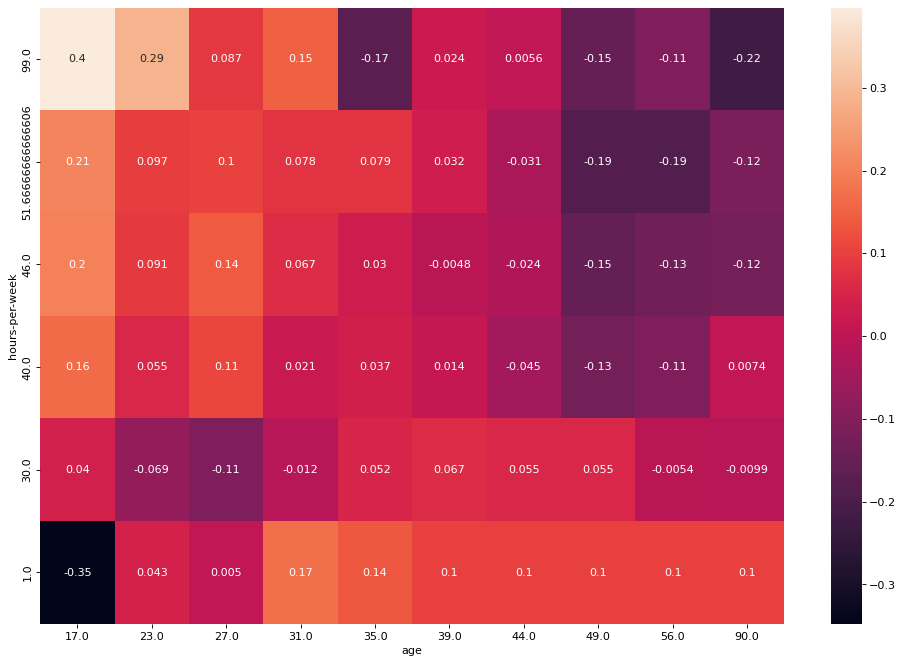

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
ax = sns.heatmap(eff_grid, annot=True)
ax.invert_yaxis()


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

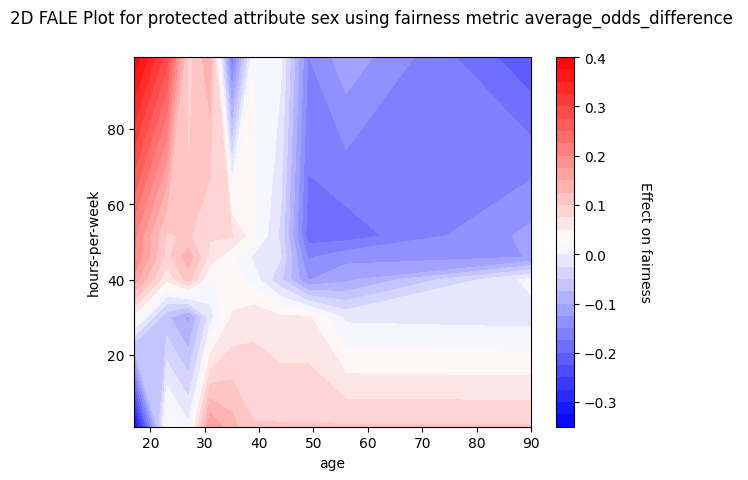

In [14]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],average_odds_difference,'sex')
plot_2D_continuous_eff(eff_grid,metric = average_odds_difference, prot_attr='sex', contour = True) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

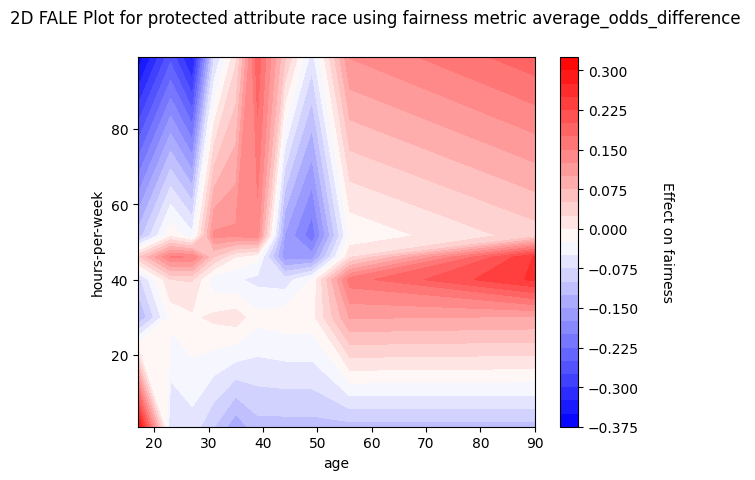

In [15]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],average_odds_difference,'race')
plot_2D_continuous_eff(eff_grid,metric = average_odds_difference, prot_attr='race', contour = True) 

### Fale 2D Plots for fairness metric `equal_opportunity_difference`

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

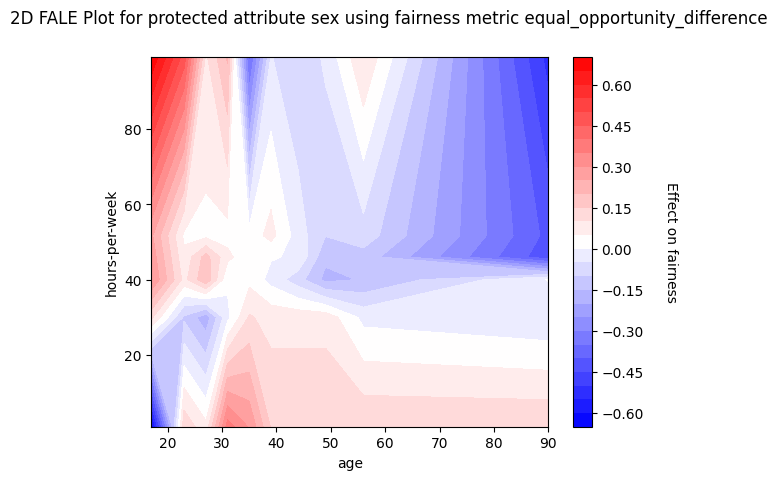

In [16]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],equal_opportunity_difference,'sex')
plot_2D_continuous_eff(eff_grid,metric = equal_opportunity_difference, prot_attr='sex', contour = True) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

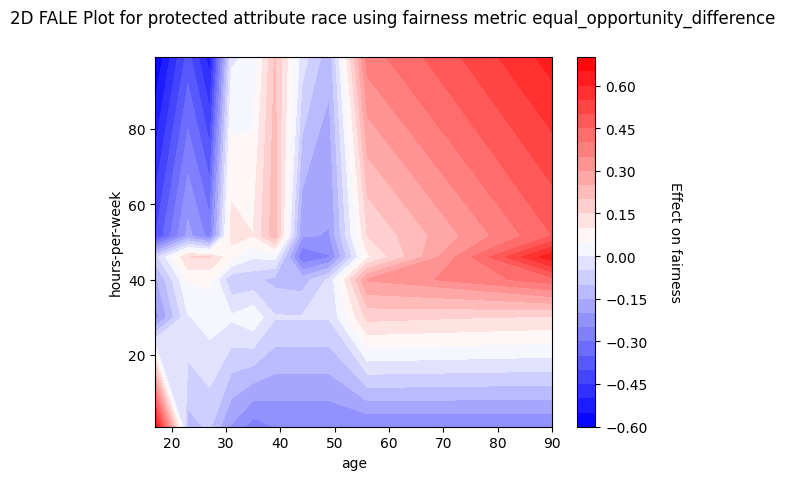

In [17]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],equal_opportunity_difference,'race')
plot_2D_continuous_eff(eff_grid,metric = equal_opportunity_difference, prot_attr='race', contour = True) 

### Fale 2D Plots for fairness metric `statistical_parity_difference`

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

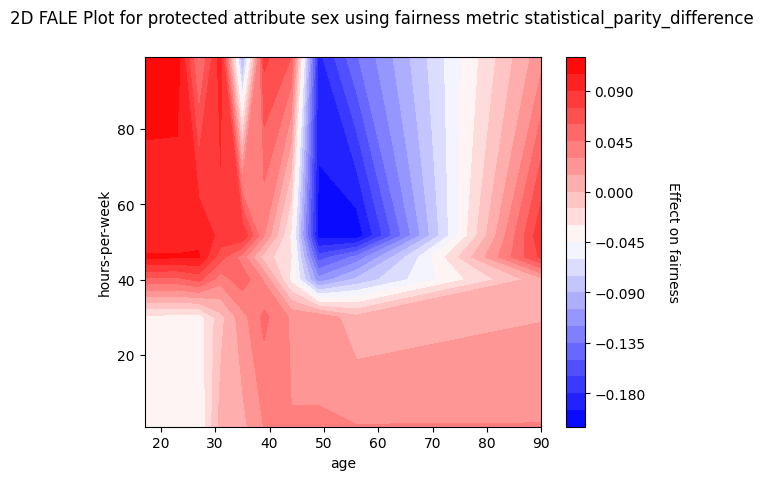

In [18]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],statistical_parity_difference,'sex')
plot_2D_continuous_eff(eff_grid,metric = statistical_parity_difference, prot_attr='sex', contour = True) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='age', ylabel='hours-per-week'>)

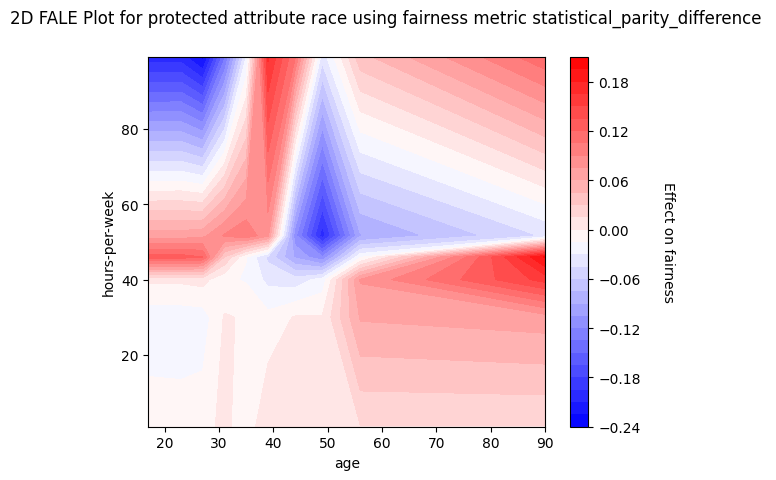

In [19]:
eff_grid = faleplot_2D_continuous(test_2d,model,['hours-per-week','age'],statistical_parity_difference,'race')
plot_2D_continuous_eff(eff_grid,metric = statistical_parity_difference, prot_attr='race', contour = True) 